## Pending
---

We need to reproduce this analysis for the FGK large sample!

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import lsdb
from tqdm import tqdm
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})
dask.config.set({"dataframe.shuffle-compression": 'Snappy'})
from dask.distributed import Client
import os
from astropy.io import ascii
from astropy.io.votable import parse
from astropy.io.votable import parse_single_table
from astropy.coordinates import SkyCoord
import astropy.units as u

In [3]:
 # magic for real time editing of .py files
%load_ext autoreload
%autoreload 2

# Custom functions and tools 
import sys
sys.path.insert(1, '../../dipper')

import tools as my_tools
import dipper as dip_pipeline
import models as dip_models
from evaluate import evaluate as evaluate
from gpmcmc import model_gp

## Digesting Photometry from IRSA

We need to accomplish the following: 
- Read the photometry [x]
- Understand and compile photometry (gri) for each unique source based on (ra, dec)
    - We will first need to compute the distance per file
- Batch call in a function per (ra, dec)

In [12]:
lc_path = "templc/"

In [63]:
all_phot_files = os.listdir(lc_path)

In [48]:
input_cat = ascii.read("../paper/my_table_again.ipac")

In [79]:
distance_metric = []
ff = []

for _ra, _dec in tqdm(zip(input_cat['ra'].data[0:1], input_cat['dec'].data[0:1])):
    
    in_c = SkyCoord(ra=_ra*u.deg, dec=_dec*u.deg)
    
    for j in range(0, len(all_phot_files)):
        table = parse_single_table(lc_path + all_phot_files[j])
        data = table.array
        A, B = np.median(data['ra']), np.median(data['dec'])
        sky_phot = SkyCoord(ra=A*u.deg, dec=B*u.deg)
        sep = in_c.separation(sky_phot).arcsec
        if sep<0.1:
            distance_metric.append(sep)
            ff.append(all_phot_files[j])
        else:
            break
        

1it [00:00,  7.75it/s]


In [80]:
distance_metric

[0.06799982745484447,
 0.08062627868882738,
 0.09092456442815443,
 0.0695839192178783]

In [83]:
data['filtercode']

masked_array(data=['zi', 'zi', 'zi', 'zi', 'zi', 'zi', 'zi', 'zi', 'zi',
                   'zi', 'zi', 'zi', 'zi', 'zi', 'zi', 'zi', 'zi', 'zi',
                   'zi', 'zi', 'zi', 'zi', 'zi', 'zi', 'zi', 'zi', 'zi',
                   'zi', 'zi', 'zi', 'zi', 'zi', 'zi', 'zi', 'zi', 'zi',
                   'zi', 'zi', 'zi', 'zi', 'zi', 'zi', 'zi', 'zi', 'zi',
                   'zi', 'zi', 'zi', 'zi', 'zi', 'zi', 'zi', 'zi', 'zi',
                   'zi', 'zi', 'zi', 'zi'],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, False,
                   False, False, False, False, False, False, False, 

In [84]:
fg = dask.dataframe.read_parquet("/epyc/ssd/users/atzanida/tmp/fg_full_feb16.parquet").compute()
#cut_1 = fg[(fg['Ndips']>0) & (fg["best_dip_power"]>3)]
#cut_1 = cut_1.head(10_000)

In [108]:
q = (fg['invNeumann']>2) & (fg['skew']>1)

In [109]:
from astropy.table import Table

In [110]:
new_t = Table.from_pandas(fg[q])

In [131]:
new_t.write("new_fg_test.csv", format='csv')

In [119]:
#new_t.keys()

In [132]:
!pwd

/astro/users/atzanida/Desktop/research/ZTF_FG_BoyajianSearch/analysis/notebooks/Tests


In [86]:
from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.io import fits
from astropy.table import QTable
from astropy.time import Time
from astropy.utils.data import download_file

from astroquery.vizier import Vizier

In [139]:
wise = pd.read_csv("1709330148392A.csv")

Text(0, 0.5, 'H-K$_{s}$')

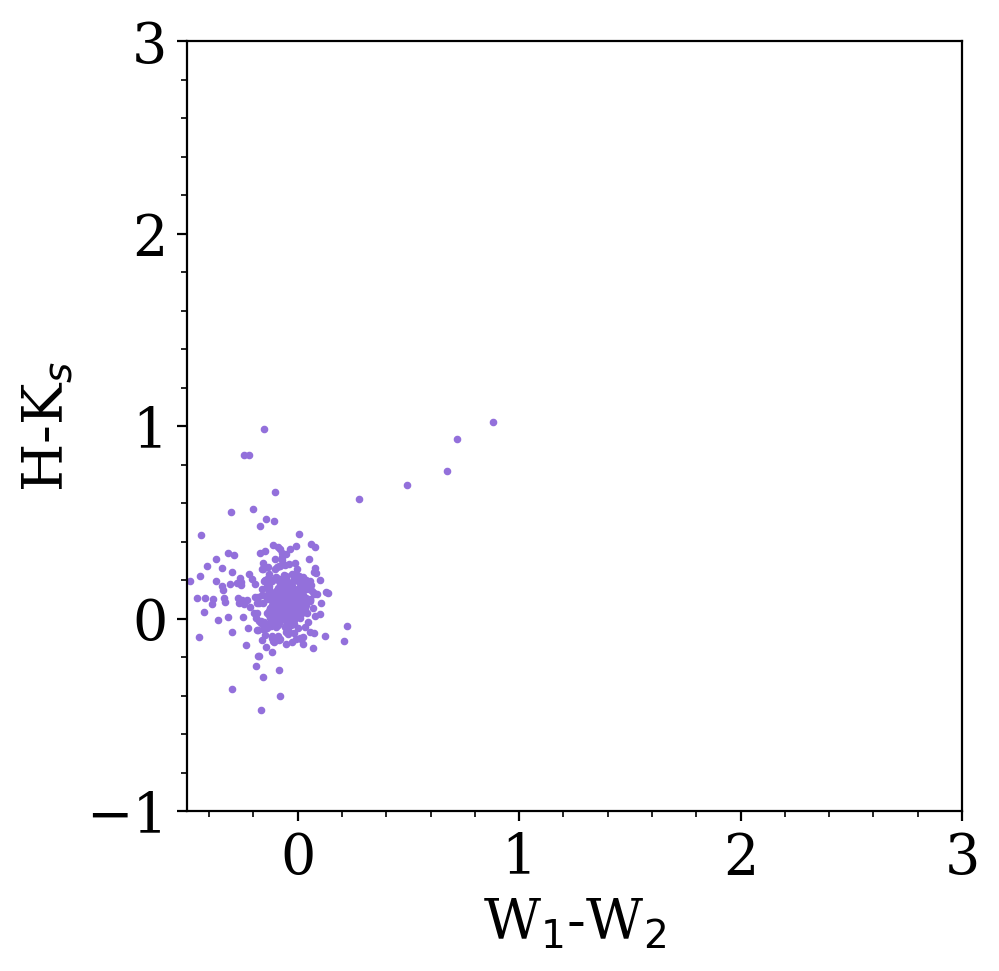

In [154]:
plt.figure(figsize=(5,5))
plt.scatter((wise['W1mag']-wise['W2mag']), (wise['Hmag']-wise['Kmag']), 
           color='mediumpurple', s=3)
plt.xlim(-0.5, 3)
plt.ylim(-1, 3)
plt.minorticks_on()
plt.xlabel("W$_{1}$-W$_{2}$")
plt.ylabel("H-K$_{s}$")

In [156]:
from astroquery.ipac.irsa import Irsa

In [200]:
Sky = SkyCoord(ra=83.8200000*u.deg, dec=-5.3899999*u.deg)

In [203]:
%%time
# II/246 is the catalog name for the main 2MASS photometric catalog
v = Vizier(catalog="II/328", columns=['*'])  
v.ROW_LIMIT = -1

result = v.query_region(Sky, radius=10*u.deg)
tmass_table = result[0]

CPU times: user 10min 57s, sys: 19.1 s, total: 11min 16s
Wall time: 14min 13s


In [211]:
q2 = (~np.isnan(tmass_table['W1mag'])) & (~np.isnan(tmass_table['W2mag'])) & (~np.isnan(tmass_table['Hmag'])) & (~np.isnan(tmass_table['Kmag']))

In [221]:
J, X, Y = np.histogram2d((tmass_table['W1mag'][q2]-tmass_table['W2mag'][q2]),
                         (tmass_table['Hmag'][q2]-tmass_table['Kmag'][q2]),
                        bins=(450, 450))

/tmp/ipykernel_111650/74073780.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(J.T), origin='lower', extent=[X[0], X[-1], Y[0], Y[-1]],


Text(0, 0.5, 'H-K$_{s}$')

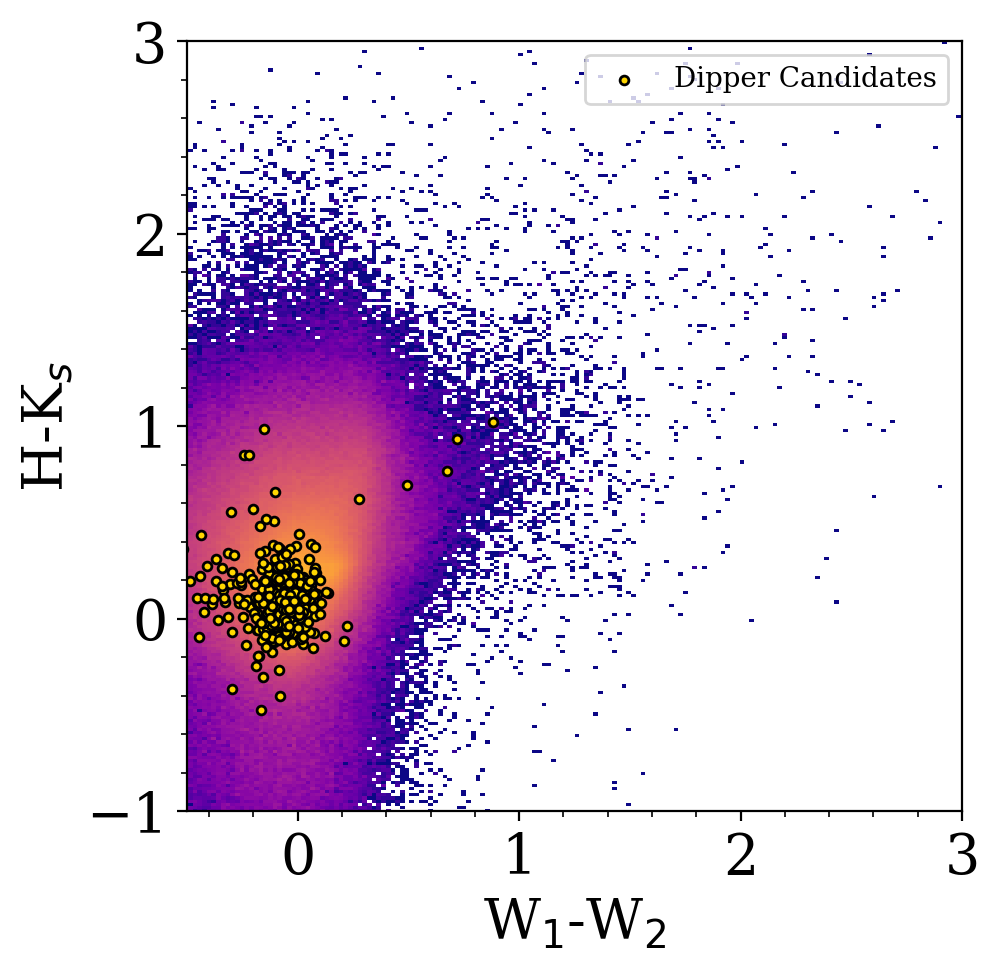

In [222]:
plt.figure(figsize=(5,5))


plt.imshow(np.log10(J.T), origin='lower', extent=[X[0], X[-1], Y[0], Y[-1]], 
          aspect='auto', 
          cmap='plasma')

plt.scatter((wise['W1mag']-wise['W2mag']), (wise['Hmag']-wise['Kmag']), 
           color='gold', s=10, edgecolor='k', 
           label='Dipper Candidates')

plt.legend(fontsize=10)

plt.xlim(-0.5, 3)
plt.ylim(-1, 3)
plt.minorticks_on()
plt.xlabel("W$_{1}$-W$_{2}$")
plt.ylabel("H-K$_{s}$")

In [141]:
for j in wise.keys():
    print (j)

angDist
ra_gaia
dec_gaia
parallax_gaia
parallax_over_error_gaia
bp_rp_gaia
solution_id_gaia
source_id_gaia
pmra_gaia
pmra_error_gaia
pmdec_gaia
pmdec_error_gaia
parallax_error_gaia
phot_g_mean_mag_gaia
l_gaia
b_gaia
non_single_star_gaia
classprob_dsc_combmod_galaxy_gaia
classprob_dsc_combmod_star_gaia
in_qso_candidates_gaia
teff_gspphot_gaia
teff_gspphot_upper_gaia
teff_gspphot_lower_gaia
logg_gspphot_gaia
logg_gspphot_lower_gaia
logg_gspphot_upper_gaia
mh_gspphot_gaia
mh_gspphot_lower_gaia
mh_gspphot_upper_gaia
distance_gspphot_gaia
distance_gspphot_lower_gaia
distance_gspphot_upper_gaia
azero_gspphot_gaia
azero_gspphot_lower_gaia
azero_gspphot_upper_gaia
ag_gspphot_gaia
ebpminrp_gspphot_gaia
ebpminrp_gspphot_lower_gaia
ebpminrp_gspphot_upper_gaia
Norder_gaia
Npix_gaia
Dir_gaia
ps1_objid_ztf_dr14
ra_ztf_dr14
dec_ztf_dr14
ps1_gMeanPSFMag_ztf_dr14
ps1_rMeanPSFMag_ztf_dr14
ps1_iMeanPSFMag_ztf_dr14
nobs_g_ztf_dr14
nobs_r_ztf_dr14
nobs_i_ztf_dr14
mean_mag_g_ztf_dr14
mean_mag_r_ztf_dr14
mea